In [1]:
pip install -U setuptools wheel

In [3]:
!pip install wikipedia-api


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14345 sha256=05946e3163e1bf52e18b7160c3bf7ad98dc3350ffbf24d57fb20b738a9ceb921
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [5]:
!pip install textacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.9 MB/s eta 0:00:00


In [7]:
!pip install dateparser==1.1.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 5.6 MB/s eta 0:00:00


In [8]:
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2

## for text
import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re

## for nlp
import spacy  #3.5.0
from spacy import displacy
import textacy  #0.12.0

## for graph
import networkx as nx  #3.0 (also pygraphviz==1.10)

## for timeline
import dateparser #1.1.7

In [10]:
import wikipediaapi

topic = "Russo-Ukrainian War"

# Define a user agent string (replace with your own information)
user_agent = "MyWikipediaBot/1.0 (example@example.com)"

# Initialize the Wikipedia object with the user agent
wiki = wikipediaapi.Wikipedia(language='en',
                             user_agent=user_agent,
                             extract_format=wikipediaapi.ExtractFormat.WIKI)
page = wiki.page(topic)
txt = page.text[:page.text.find("See also")]
txt[0:500] + " ..."

"The Russo-Ukrainian War began in February 2014. Following Ukraine's Revolution of Dignity, Russia occupied and annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas War. These first eight years of conflict also included naval incidents and cyberwarfare. In February 2022, Russia launched a full-scale invasion of Ukraine and began occupying more of the country, starting the biggest conflict in Europe since World War II. The war has resulted ..."

In [11]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

In [12]:
lst_docs = [sent for sent in doc.sents]
print("tot sentences:", len(lst_docs))

tot sentences: 520


In [14]:
i=3
for token in lst_docs[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

In --> pos: ADP | dep: prep 
February --> pos: PROPN | dep: pobj 
2022 --> pos: NUM | dep: nummod 
, --> pos: PUNCT | dep: punct 
Russia --> pos: PROPN | dep: nsubj 
launched --> pos: VERB | dep: ROOT 
a --> pos: DET | dep: det 
full --> pos: ADJ | dep: amod 
- --> pos: PUNCT | dep: punct 
scale --> pos: NOUN | dep: compound 
invasion --> pos: NOUN | dep: dobj 
of --> pos: ADP | dep: prep 
Ukraine --> pos: PROPN | dep: pobj 
and --> pos: CCONJ | dep: cc 
began --> pos: VERB | dep: conj 
occupying --> pos: VERB | dep: xcomp 
more --> pos: ADJ | dep: dobj 
of --> pos: ADP | dep: prep 
the --> pos: DET | dep: det 
country --> pos: NOUN | dep: pobj 
, --> pos: PUNCT | dep: punct 
starting --> pos: VERB | dep: advcl 
the --> pos: DET | dep: det 
biggest --> pos: ADJ | dep: amod 
conflict --> pos: NOUN | dep: dobj 
in --> pos: ADP | dep: prep 
Europe --> pos: PROPN | dep: pobj 
since --> pos: SCONJ | dep: prep 
World --> pos: PROPN | dep: compound 
War --> pos: PROPN | dep: compound 
II --> 

In [15]:
from spacy import displacy

displacy.render(lst_docs[i], style="dep", options={"distance":100})

In [16]:
for tag in lst_docs[i].ents:
    print(tag.text, f"({tag.label_})")

February 2022 (DATE)
Russia (GPE)
Ukraine (GPE)
Europe (LOC)
World War II (EVENT)


In [17]:
displacy.render(lst_docs[i], style="ent")

In [18]:
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            ## prexif --> prev_compound + compound
            if token.dep_ == "compound":
                prefix = prev_txt +" "+ token.text if prev_dep == "compound" else token.text

            ## modifier --> prev_compound + %mod
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt +" "+ token.text if prev_dep == "compound" else token.text

            ## subject --> modifier + prefix + %subj
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""

            ## if object --> modifier + prefix + %obj
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text

            prev_dep, prev_txt = token.dep_, token.text

    # clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())


# The relation extraction requires the rule-based matching tool,
# an improved version of regular expressions on raw text.
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'},
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}]
    matcher.add(key="matching_1", patterns=[p1])
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]
    return span.text

In [19]:
lst_entities = [extract_entities(i) for i in lst_docs]

## example
lst_entities[i]

('2022 Russia', 'biggest World War II')

In [20]:
lst_relations = [extract_relation(i,nlp) for i in lst_docs]

## example
lst_relations[i]

'launched'

In [21]:
lst_attr = []
for x in lst_docs:
    attr = ""
    for tag in x.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

## example
lst_attr[i]

'February 2022'

In [22]:
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)


## create dataframe
dtf = pd.DataFrame(dic)

## example
dtf[dtf["id"]==i]

,id,text,entity,relation,object
4,3,"In February 2022, Russia launched a full-scale...",Russia,launched,scale_invasion
5,3,"In February 2022, Russia launched a full-scale...",Russia,began,"occupying_more_of_the_country_,"


In [37]:
attribute = "DATE"
dic = {"id":[], "text":[], attribute:[]}

for n,sentence in enumerate(lst_docs):
    lst = list(textacy.extract.entities(sentence, include_types={attribute}))
    if len(lst) > 0:
        for attr in lst:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(str(attr))
    else:
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic[attribute].append(np.nan)

dtf_att = pd.DataFrame(dic)
dtf_att = dtf_att[~dtf_att[attribute].isna()]

# example
dtf_att[dtf_att["id"]==i]

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


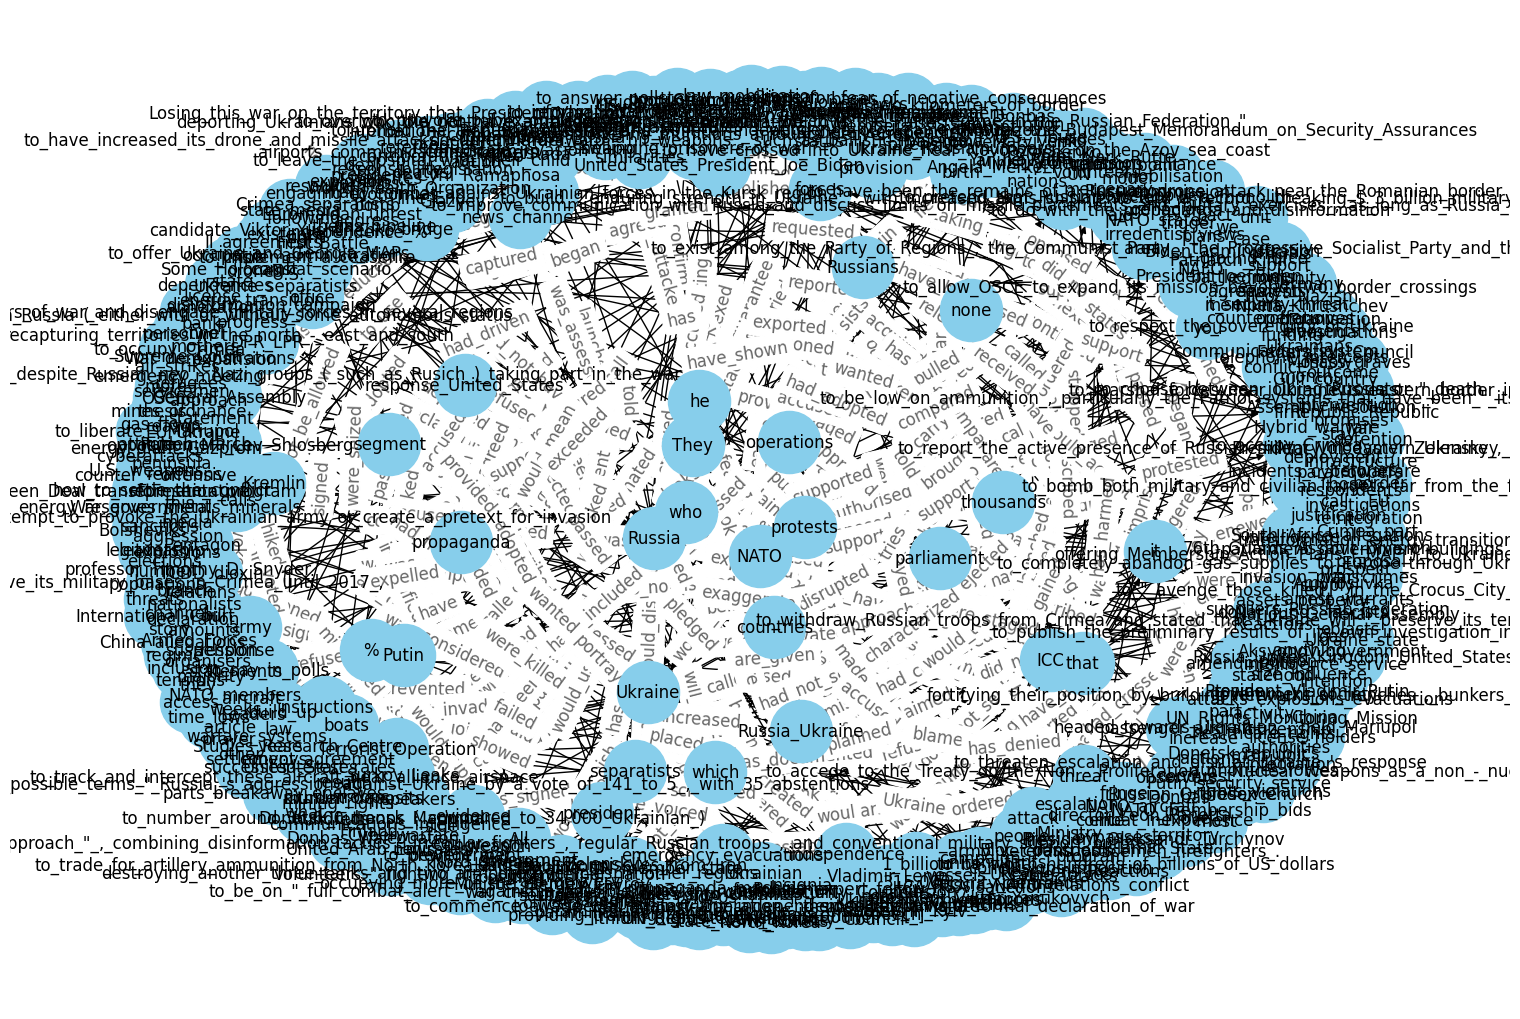

In [24]:
G = nx.from_pandas_edgelist(dtf, source="entity", target="object",
                            edge_attr="relation",
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color,
        edge_color=edge_color, cmap=plt.cm.Dark2,
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5,
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()

In [27]:
!apt install libgraphviz-dev
!pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


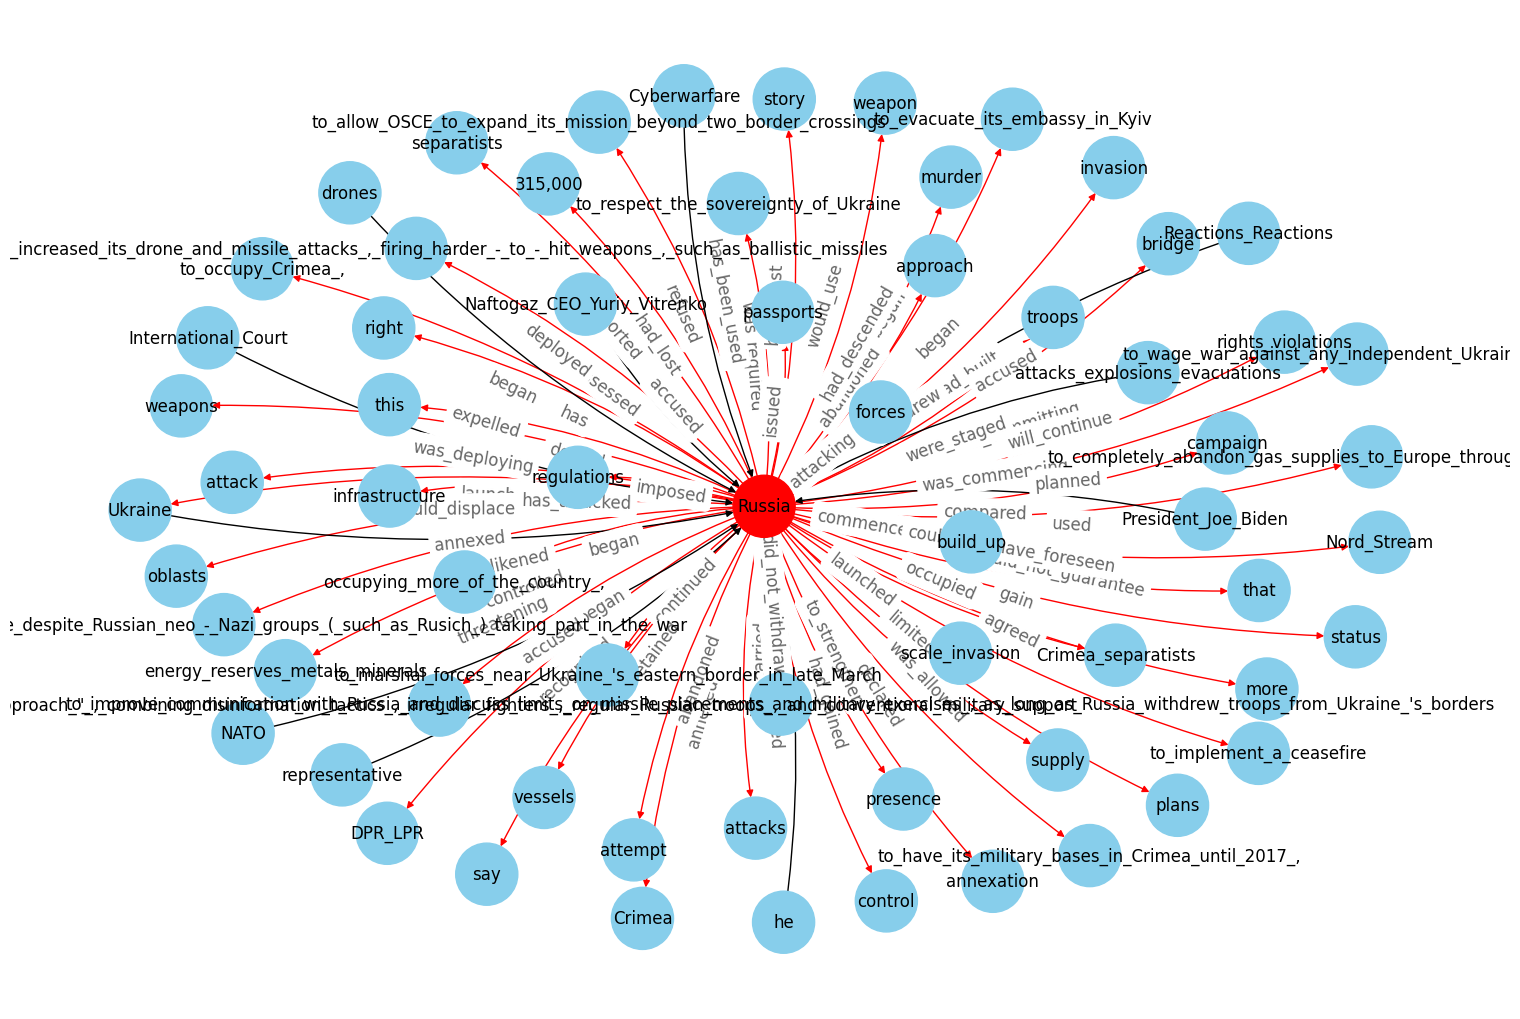

In [28]:
f = "Russia"
tmp = dtf[(dtf["entity"]==f) | (dtf["object"]==f)]


## create small graph
G = nx.from_pandas_edgelist(tmp, source="entity", target="object",
                            edge_attr="relation",
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
node_color = ["red" if node==f else "skyblue" for node in G.nodes]
edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

nx.draw(G, pos=pos, with_labels=True, node_color=node_color,
        edge_color=edge_color, cmap=plt.cm.Dark2,
        node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5,
                        edge_labels=nx.get_edge_attributes(G,'relation'),
                        font_size=12, font_color='black', alpha=0.6)
plt.show()

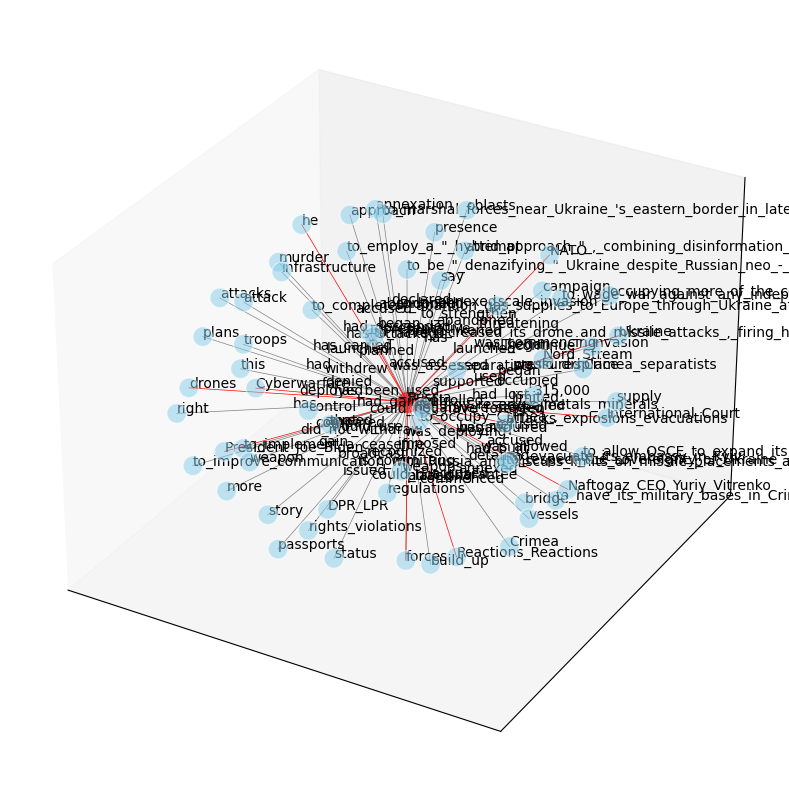

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="3d")
pos = nx.spring_layout(G, k=2.5, dim=3)

nodes = np.array([pos[v] for v in sorted(G) if v!=f])
center_node = np.array([pos[v] for v in sorted(G) if v==f])

edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v!=f])
center_edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v==f])

ax.scatter(*nodes.T, s=200, ec="w", c="skyblue", alpha=0.5)
ax.scatter(*center_node.T, s=200, c="red", alpha=0.5)

for link in edges:
    ax.plot(*link.T, color="grey", lw=0.5)
for link in center_edges:
    ax.plot(*link.T, color="red", lw=0.5)

for v in sorted(G):
    ax.text(*pos[v].T, s=v)
for u,v in G.edges():
    attr = nx.get_edge_attributes(G, "relation")[(u,v)]
    ax.text(*((pos[u]+pos[v])/2).T, s=attr)

ax.set(xlabel=None, ylabel=None, zlabel=None,
       xticklabels=[], yticklabels=[], zticklabels=[])
ax.grid(False)
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])
plt.show()

In [30]:
def utils_parsetime(txt):
    x = re.match(r'.*([1-3][0-9]{3})', txt) #<--check if there is a year
    if x is not None:
        try:
            dt = dateparser.parse(txt)
        except:
            dt = np.nan
    else:
        dt = np.nan
    return dt

In [32]:
dtf_att["dt"] = dtf_att["DATE"].apply(lambda x: utils_parsetime(x))

## example
dtf_att[dtf_att["id"]==i]

,id,text,DATE,dt
3,3,"In February 2022, Russia launched a full-scale...",February 2022,2022-02-24


In [33]:
tmp = dtf.copy()
tmp["y"] = tmp["entity"]+" "+tmp["relation"]+" "+tmp["object"]

dtf_att = dtf_att.merge(tmp[["id","y"]], how="left", on="id")
dtf_att = dtf_att[~dtf_att["y"].isna()].sort_values("dt",
                 ascending=True).drop_duplicates("y", keep='first')
dtf_att.head()

,id,text,DATE,dt,y
166,227,He incorrectly stated that Vladimir Lenin had ...,1954,1954-12-24,Vladimir_Lenin had_created Ukraine
168,227,He incorrectly stated that Vladimir Lenin had ...,1954,1954-12-24,Nikita_Khrushchev took Crimea
167,227,He incorrectly stated that Vladimir Lenin had ...,1954,1954-12-24,Putin said what
169,227,He incorrectly stated that Vladimir Lenin had ...,1954,1954-12-24,Vladimir_Lenin gave it
20,27,After the dissolution of the Soviet Union (USS...,1991,1991-12-24,Ukraine_Russia maintained ties


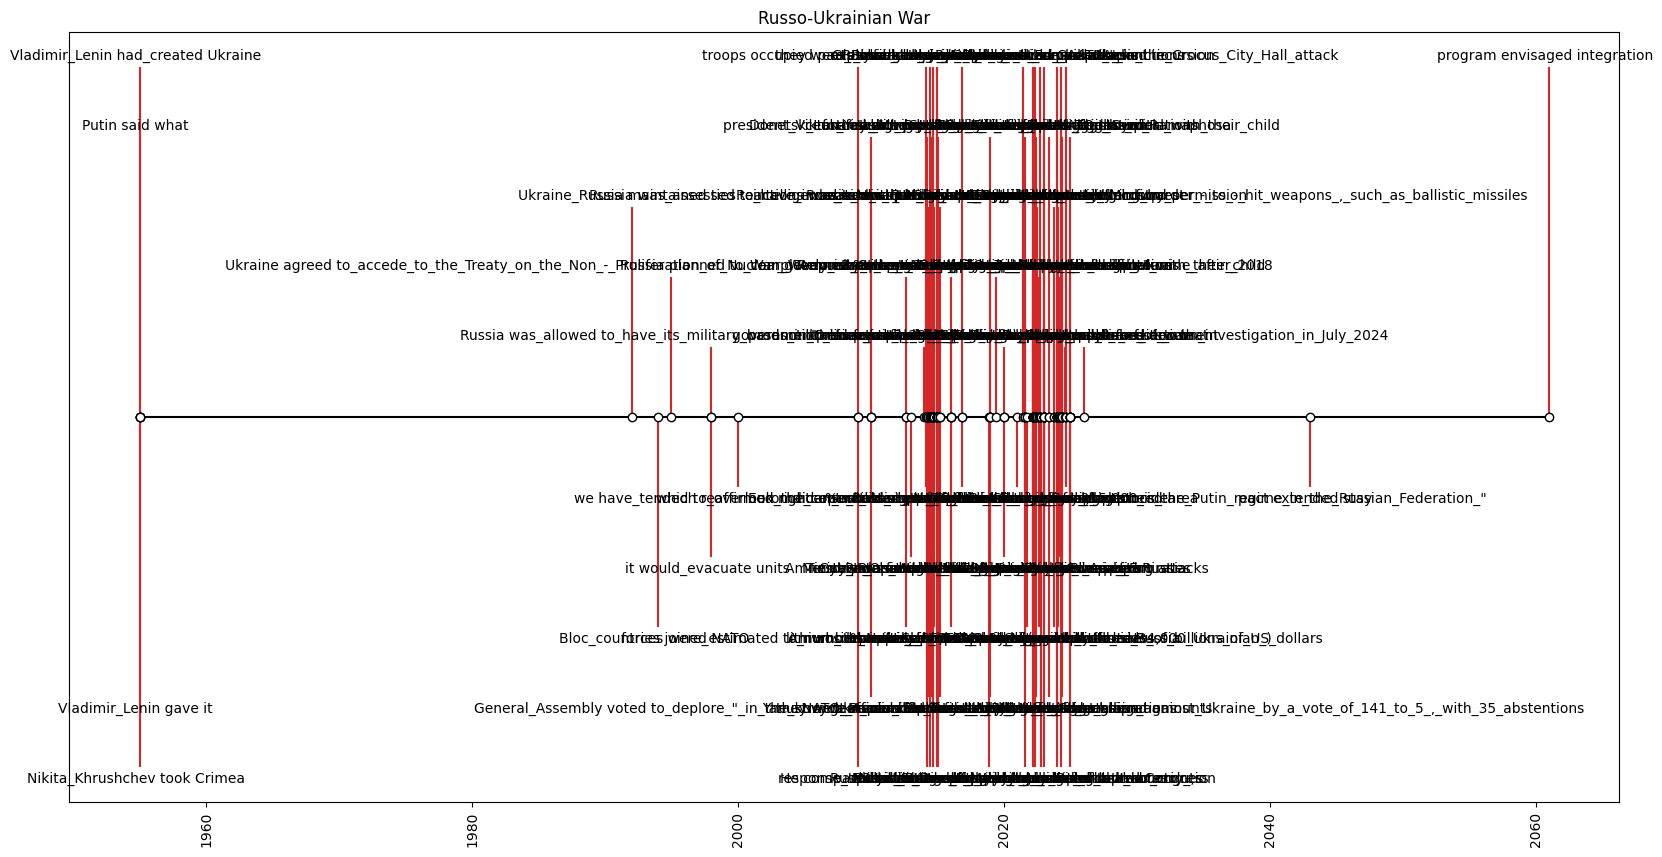

In [34]:
dates = dtf_att["dt"].values
names = dtf_att["y"].values
l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

fig, ax = plt.subplots(figsize=(20,10))
ax.set(title=topic, yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90)
plt.show()

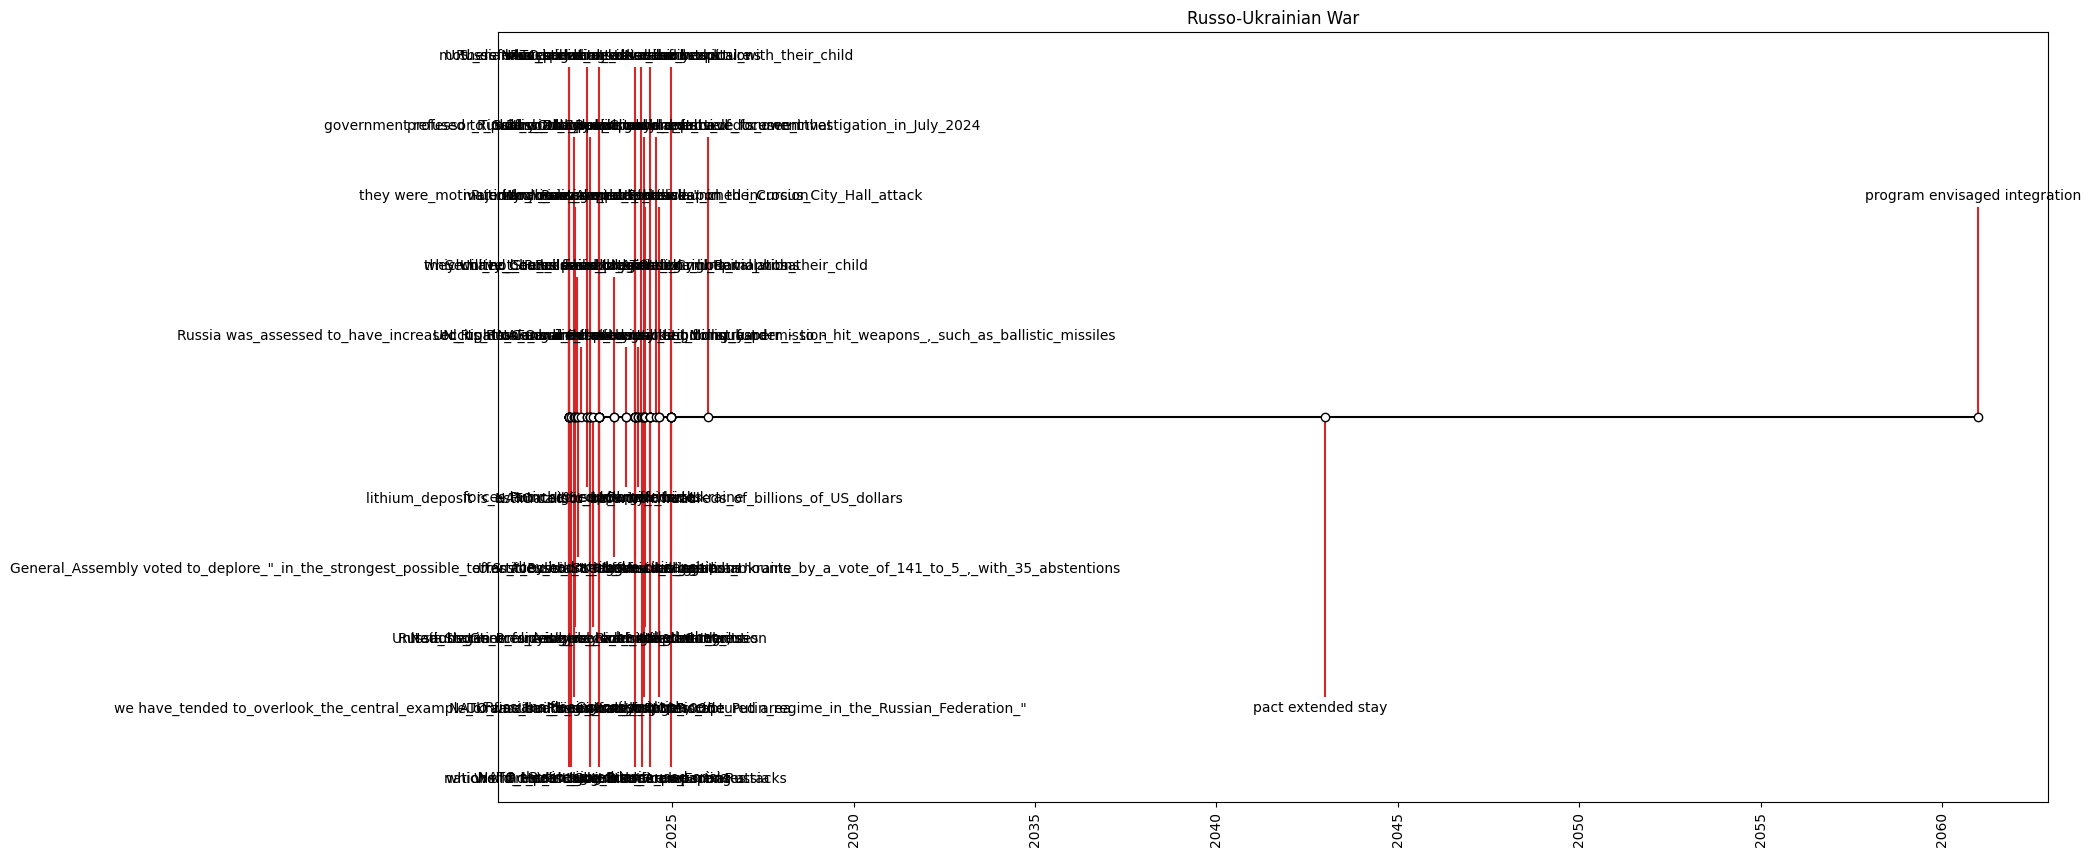

In [35]:
yyyy = "2022"
dates = dtf_att[dtf_att["dt"]>yyyy]["dt"].values
names = dtf_att[dtf_att["dt"]>yyyy]["y"].values
l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

fig, ax = plt.subplots(figsize=(20,10))
ax.set(title=topic, yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90)
plt.show()